# SOS:
- I definitely have a memory leak somewhere and I need to figure out where. Because swap space only increases as I run the code.

# Immediate Goals:
- Forget about memory leak, work around it for now
- [X] Make sure operations are correct and indeed I have the algorithm as I want it ( add local inter stop )

As soon as the algorithm is "correct" no matter the performance, I can run my tests and see what the paper is about. Then a good c++ implementation will just make cracking work.

- [ ] Create skewed dataset & non-skewed dataset:
    - [ ] QPS before crack? QPS after crack? QPS full train?
    - if I "freeze" it after crack and re-run I can check if the crack was useful and I achieve comparable QPS will full training
- [ ] Estimate analytically what I save from training, what QPS do I need to achieve for this to be a good idea

- Examples: https://github.com/facebookresearch/faiss/wiki/Python-C---code-snippets

- replace invlists:
    - (!--SLOW) How can I replace invlist content: https://gist.github.com/mdouze/aef2078afdb12c027ed93672d9801399#file-demo_replace_invlists-ipynb
    - (!--FASTER i think) implement evolving dataset (update/delets) : https://github.com/facebookresearch/faiss/wiki/Case-studies#implementing-an-evolving-ivf-dataset
    - (!) how to add_preassigned, to add points to specific invlists: use https://gist.github.com/mdouze/8c5ab227c0f7d9d7c15cf92a391dcbe5#file-demo_independent_ivf_dimension-ipynb
    - clear and re-add pts to specific invlist: https://github.com/facebookresearch/faiss/issues/2311
        - use add_preassigned to re-add to specific list (make sure you change quantizer as well)
        - doing this on GPU: https://github.com/facebookresearch/faiss/issues/3908
- kmeans inner iter:
    - (!) How to force k-means initializations: https://gist.github.com/mdouze/9eb96d941c94ef59482a069e5862a650 
    - To avoid copies of the data, eg IndexFlat there is brute force search to run directly on data (without creating index): https://github.com/facebookresearch/faiss/wiki/
    - (!) how to warm start centroid training when you have drifts: 
        - https://gist.github.com/mdouze/fd0e3e1f20a3d530d96b0e017050df43#file-warm_start_ivf_centroids-ipynb 
        - https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-warm-start-the-centroid-training-for-an-ivf-index

- other:
    - (!) How to get content of inverted lists? https://github.com/facebookresearch/faiss/wiki/Python-C---code-snippets#how-can-i-get-the-content-of-inverted-lists
        - data is not copied with get_invlist (https://gist.github.com/mdouze/b0a65aba70a64b00d6425b0e268a4c80)
    - (!) how to replace quantizer: https://github.com/facebookresearch/faiss/blob/697b6ddf558ef4ecb60e72e828c25a69723639c1/contrib/ivf_tools.py#L98
    - get number of distance computations: https://github.com/facebookresearch/faiss/wiki/Implementation-notes#statistics-for-non-exhaustive-search
    - how to run queries with different nprobe for each etc: https://github.com/facebookresearch/faiss/wiki/Setting-search-parameters-for-one-query
    - how to do constraint k-means (~balanced): https://github.com/facebookresearch/faiss/wiki/Case-studies#limited-size-clustering


Q: why does sa_encode in IndexFlatL2 return 1 byte more 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from vasili_helpers import *
faiss.omp_set_num_threads(1)

In [ ]:
DATASET = "sift-128-euclidean"
# DATASET = "synthetic-small"
# DATASET = "synthetic-large"

In [77]:
if DATASET == "sift-128-euclidean":
    DATA_PATH = "/Users/mageirakos/Documents/projects/crack-vdb/data/" # local path
    DATA_PATH = "/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean" # sys server pub/sratch
    xb, xq, _, gt, _ = load_sift1M(DATA_PATH)
    num_centroids = 1000
elif DATASET == "synthetic-small":
    _, xb, gt, xq, _ = create_synthetic_dataset(d=3,nt=10,nb=100,nq=2,metric='L2')
    num_centroids = 10
elif DATASET == "synthetic-large":
    _, xb, gt, xq, _ = create_synthetic_dataset(d=100, nt=10, nb=1_000_000, nq=10, metric='L2')
    num_centroids = 1000
    # _, xb, gt, xq, _ = create_synthetic_dataset(d=128, nt=256_000, nb=1_000_000, nq=10_000, metric='L2') # ~SIFT1M

Loading sift1M...done


dataset shape:
xb.shape=(1000000, 128)
gt.shape=(10000, 100)
xq.shape=(10000, 128)


In [78]:
num_centroids

1000

In [18]:
outer_index = get_faiss_ivfflatL2_from_individual_components(xb, \
                                                            nlist=num_centroids, 
                                                            km_n_iter=0, 
                                                            km_max_pts=256, 
                                                            verbose=True)

trained_outer_index = get_faiss_ivfflatL2_from_individual_components(xb, \
                                                            nlist=num_centroids, 
                                                            km_n_iter=10, 
                                                            km_max_pts=256, 
                                                            verbose=True)
# print("UNTRAINED: ")
# plot_hist_invlists_faiss_index(outer_index)
# print(f"Imbalance factor = {outer_index.invlists.imbalance_factor()}")
# print("TRAINED: ")
# plot_hist_invlists_faiss_index(trained_outer_index)
# print(f"Imbalance factor = {trained_outer_index.invlists.imbalance_factor()}")

[1] Train K-means for 0 iterations on 100 points...
Clustering 100 points in 3D to 10 clusters, redo 1 times, 0 iterations
  Preprocessing in 0.00 s
[2] Initialize quantizer of 3 dimensions, with 10 centroids...
[3] IndexIVFFLat: Adding 100 points of 3 dimensions, to 10 centroids from the quantizer...

Training level-1 quantizer
IVF quantizer does not need training.
Training IVF residual
IndexIVF: no residual training

[-] Finished get_faiss_ivfflatL2_from_individual_components
- TRAIN: K-means took 0.001 s
- ADD: centroids to quantizer 0.0 s
- ADD: points to index took 0.04 s
- TOTAL time: 0.042 s
- Invlist Imbalance Factor: 1.13

[1] Train K-means for 10 iterations on 100 points...
IndexIVFFlat::add_core: added 100 / 100 vectors
Clustering 100 points in 3D to 10 clusters, redo 1 times, 10 iterations
  Preprocessing in 0.00 s
  Iteration 9 (0.00 s, search 0.00 s): objective=25.1457 imbalance=1.130 nsplit=0       
[2] Initialize quantizer of 3 dimensions, with 10 centroids...
[3] Index

WARNING clustering 100 points to 10 centroids: please provide at least 390 training points
WARNING clustering 100 points to 10 centroids: please provide at least 390 training points


##### Algo
While Queries:
1) .search() for the query
    - a) get results
    - b) get recall
    - c) get nprobe closest centroids -> "c_visited"
2) any(c_visited.iter < max_local_iter ) ? CRACK : NO_CRACK
    - a) If NO_CRACK: return results
3) if CRACK:
    - a) get all points in c_visited -> "p_visited"
    - b) use IDMap to keep track of -> point_ids & centroid_ids (outer<->inner)
    - c) initialize new inner_quantizer w/ c_visited centroids
        - single iteration of .train() on c_visited with p_visited
        - add(p_visited) using innuer_quantizer and get inner_invlists
    - d) update outer_index for the next query, to use the new:
        - inner_quantizer
        - inner_invlists 
    
------

Notes on the above:
- 1c) there's not cheap way to get it in python, there is a smart pointer that poitns to object which holds c_visited (called idx) when sub_search_func() is called in indexivf.cpp search
    -  I would have to change internals to optionally return this to have it "for free"

NOTE:
- Timings in fdr3 are highly unstable ( at least on the small dataset )

In [19]:
#NOTE: create full copy of outer_index because run_crack_ivf changes it inplace
OUTER_INDEX_CLONE = faiss.clone_index(outer_index)

Default testing cracking:


In [61]:
%%time
run_crack_ivf(outer_index, xq, gt, \
    nprobe=2, 
    k=10, 
    inner_km_niter=1, 
    # limit_query=100,
    # CRACK=True, 
    # plot_boxplot=True, 
    # limit_crack=1,
    # dynamic_nprobe=True,
    # DEBUG=True,
)


[-] Finished run_crack_ivf:
--- Median Timings for Each Section ---
- search: 0.000160 seconds
- get_c_visited: 0.000069 seconds
- get_p_visited: 0.0 seconds
- inner_km_train: 0.0 seconds
- inner_point_assignments: 0.0 seconds
- replace_quantizer: 0.0 seconds
- update_invlists: 0.0 seconds

--- Total Timings for Each Section ---
- search: 0.000319 seconds
- get_c_visited: 0.000139 seconds
- get_p_visited: 0.0 seconds
- inner_km_train: 0.0 seconds
- inner_point_assignments: 0.0 seconds
- replace_quantizer: 0.0 seconds
- update_invlists: 0.0 seconds
- Invlist Imbalance Factor : 1.13
- Recalls@10: np.median(recalls)=0.9 - np.mean(recalls)=0.9 - round(np.std(recalls),3)=0.1
-% points scanned : nan (median) - nan (mean) 
CPU times: user 602 μs, sys: 3.46 ms, total: 4.07 ms
Wall time: 3.22 ms


In [75]:
%%time
#NOTE: create full copy of outer_index because run_crack_ivf changes it inplace
# OUTER_INDEX_CLONE = faiss.clone_index(outer_index)

run_crack_ivf(OUTER_INDEX_CLONE, xq, gt, \
    nprobe=2, 
    k=10, 
    inner_km_niter=1, 
    # limit_query=100,
    CRACK=True, 
    # plot_boxplot=True, 
    # limit_crack=1,
    # dynamic_nprobe=True,
    # DEBUG=True,
)

IndexIVFFlat::add_core: added 24 / 24 vectors

[-] Finished run_crack_ivf:
--- Median Timings for Each Section ---
IndexIVFFlat::add_core: added 29 / 29 vectors
- search: 0.000351 seconds
- get_c_visited: 0.000085 seconds
- get_p_visited: 0.000173 seconds
- inner_km_train: 0.000454 seconds
- inner_point_assignments: 0.000061 seconds
- replace_quantizer: 0.000277 seconds
- update_invlists: 0.000124 seconds

--- Total Timings for Each Section ---
- search: 0.000701 seconds
- get_c_visited: 0.000169 seconds
- get_p_visited: 0.000347 seconds
- inner_km_train: 0.000908 seconds
- inner_point_assignments: 0.000122 seconds
- replace_quantizer: 0.000555 seconds
- update_invlists: 0.000248 seconds
- Invlist Imbalance Factor : 1.146
- Recalls@10: np.median(recalls)=0.85 - np.mean(recalls)=0.85 - round(np.std(recalls),3)=0.15
-% points scanned : 0.265 (median) - 0.265 (mean) 
CPU times: user 8.67 ms, sys: 118 μs, total: 8.78 ms
Wall time: 6.97 ms


WARNING clustering 24 points to 2 centroids: please provide at least 78 training points
WARNING clustering 29 points to 2 centroids: please provide at least 78 training points


Testing what would happen if we have very skewed query set:

In [14]:
xq_shuffled, gt_shuffled = shuffle_queries(xq, gt, seed=42)

- Total number of unique centroids visited: 171
- % of total centroids: 17.0 %


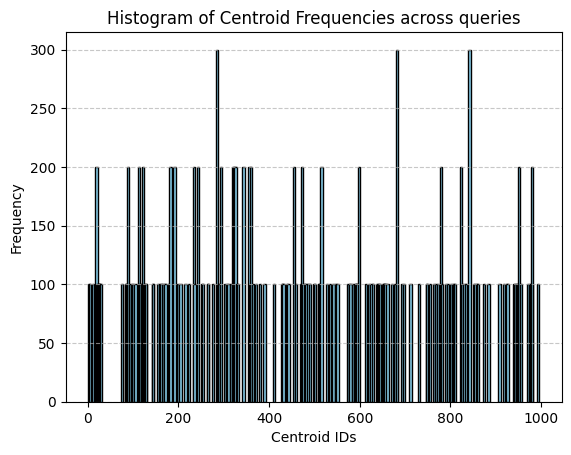

In [646]:
nprobe=10
xq_shuffled, gt_shuffled = shuffle_queries(xq, gt, seed=42)
limit_queries=20
factor_of_duplication=100
subset_xq = xq_shuffled[:limit_queries].reshape(limit_queries,-1)
subset_gt = gt_shuffled[:limit_queries].reshape(limit_queries,-1)
subset_DUPLICATED, gt_DUPLICATED = increase_queries_by_duplicates(subset_xq, subset_gt, factor=factor_of_duplication)
get_centroid_ids_per_query(
    outer_index, 
    subset_DUPLICATED, 
    nprobe=10, 
    plot_hist=True
    )

In [705]:
NPROBE = 10

In [706]:
%%time
## UNTRAINED outer index
run_crack_ivf(
    # OUTER_INDEX_CLONE,  #THE ONE BEING CRACKED (COPY)
    outer_index, #BEFORE (NO CRACK)
    # xq, 
    subset_DUPLICATED,
    # gt,
    gt_DUPLICATED,
    nprobe=NPROBE, 
    k=100, 
    inner_km_niter=1, 
    # limit_query=100,
    # CRACK=True, 
    # plot_boxplot=True, 
    # DEBUG=True,
    )


[-] Finished run_crack_ivf:
--- Median Timings for Each Section ---
- search: 0.000959 seconds
- get_c_visited: 0.000065 seconds
- get_p_visited: 0.0 seconds
- inner_km_train: 0.0 seconds
- inner_point_assignments: 0.0 seconds
- replace_quantizer: 0.0 seconds
- update_invlists: 0.0 seconds

--- Total Timings for Each Section ---
- search: 2.013371 seconds
- get_c_visited: 0.137494 seconds
- get_p_visited: 0.0 seconds
- inner_km_train: 0.0 seconds
- inner_point_assignments: 0.0 seconds
- replace_quantizer: 0.0 seconds
- update_invlists: 0.0 seconds
- Invlist Imbalance Factor : 1.808352322
- Recalls@100: np.median(recalls)=0.78 - np.mean(recalls)=0.78 - round(np.std(recalls),3)=0.132
-% points scanned : nan (median) - nan (mean) 
CPU times: user 2.67 s, sys: 3.7 ms, total: 2.67 s
Wall time: 2.66 s


In [707]:
%%time
## UNTRAINED outer index
run_crack_ivf(
    # OUTER_INDEX_CLONE,  #THE ONE BEING CRACKED (COPY)
    trained_outer_index, #BEFORE (NO CRACK)
    # xq, 
    subset_DUPLICATED,
    # gt,
    gt_DUPLICATED,
    nprobe=NPROBE, 
    k=100, 
    inner_km_niter=1, 
    # limit_query=100,
    # CRACK=True, 
    # plot_boxplot=True, 
    # DEBUG=True,
    )


[-] Finished run_crack_ivf:
--- Median Timings for Each Section ---
- search: 0.000586 seconds
- get_c_visited: 0.000064 seconds
- get_p_visited: 0.0 seconds
- inner_km_train: 0.0 seconds
- inner_point_assignments: 0.0 seconds
- replace_quantizer: 0.0 seconds
- update_invlists: 0.0 seconds

--- Total Timings for Each Section ---
- search: 1.275593 seconds
- get_c_visited: 0.133411 seconds
- get_p_visited: 0.0 seconds
- inner_km_train: 0.0 seconds
- inner_point_assignments: 0.0 seconds
- replace_quantizer: 0.0 seconds
- update_invlists: 0.0 seconds
- Invlist Imbalance Factor : 1.124995972
- Recalls@100: np.median(recalls)=0.8200000000000001 - np.mean(recalls)=0.799 - round(np.std(recalls),3)=0.154
-% points scanned : nan (median) - nan (mean) 
CPU times: user 1.91 s, sys: 7.47 ms, total: 1.92 s
Wall time: 1.91 s


Testing if training locally helps at all...

In [712]:
#NOTE: create full copy of outer_index because run_crack_ivf changes it inplace
OUTER_INDEX_CLONE = faiss.clone_index(outer_index)

In [715]:
%%time
## UNTRAINED outer index &&&& CRACKING
run_crack_ivf(
    OUTER_INDEX_CLONE,  #THE ONE BEING CRACKED (COPY)
    # xq, 
    subset_DUPLICATED,
    # gt,
    gt_DUPLICATED,
    nprobe=NPROBE, 
    k=100, 
    inner_km_niter=1,
    # limit_query=1,
    limit_crack=1*len(subset_DUPLICATED)//factor_of_duplication,
    CRACK=True, 
    dynamic_nprobe=True,
    # plot_boxplot=True, 
    # DEBUG=True,
    )

IndexIVFFlat::add_core: added 27015 / 27015 vectors
IndexIVFFlat::add_core: added 43322 / 43322 vectors
IndexIVFFlat::add_core: added 40305 / 40305 vectors
IndexIVFFlat::add_core: added 44743 / 44743 vectors
IndexIVFFlat::add_core: added 39889 / 39889 vectors
IndexIVFFlat::add_core: added 23674 / 23674 vectors
IndexIVFFlat::add_core: added 46930 / 46930 vectors
IndexIVFFlat::add_core: added 48272 / 48272 vectors
IndexIVFFlat::add_core: added 29823 / 29823 vectors
IndexIVFFlat::add_core: added 33794 / 33794 vectors
IndexIVFFlat::add_core: added 42999 / 42999 vectors
IndexIVFFlat::add_core: added 38957 / 38957 vectors
IndexIVFFlat::add_core: added 49099 / 49099 vectors
IndexIVFFlat::add_core: added 39749 / 39749 vectors
IndexIVFFlat::add_core: added 30429 / 30429 vectors
IndexIVFFlat::add_core: added 35279 / 35279 vectors
IndexIVFFlat::add_core: added 28485 / 28485 vectors
IndexIVFFlat::add_core: added 48683 / 48683 vectors
IndexIVFFlat::add_core: added 46400 / 46400 vectors
IndexIVFFlat

# Debugging

In [485]:
import time
import numpy as np
import faiss

for q in xq[:1, :]:
    # 1. search
    start_time = time.perf_counter()  # Timer starts
    q = q.reshape(1, -1)
    outer_index.nprobe = nprobe  
    D_p, I_p = outer_index.search(q, k)
    end_time = time.perf_counter()  # Timer ends
    print(f"Time for '.search()': {end_time - start_time:.6f} seconds")
    
    # 1c. get c_visited
    start_time = time.perf_counter()  # Timer starts
    c_visited_ids = outer_index.quantizer.search(q, nprobe)[1][0]  # Get nprobe nearest centroids to query
    c_visited = outer_centroids[c_visited_ids]
    end_time = time.perf_counter()  # Timer ends
    print(f"Time for 'get c_visited': {end_time - start_time:.6f} seconds")

    if not CRACK:
        continue
    else:
        # CRACK: 

        # 2a) get p_visited
        start_time = time.perf_counter()  # Timer starts
        tmp_pids, tmp_codes = [], []
        for cid in c_visited_ids:
            pids, codes = get_invlist(outer_index.invlists, int(cid)) 
            tmp_pids.append(pids)
            tmp_codes.append(codes)
        pids_visited = np.concatenate(tmp_pids, axis=0)
        p_visited = np.concatenate(tmp_codes, axis=0).view("float32")  # Convert uint8 bytes to float32 
        end_time = time.perf_counter()  # Timer ends
        print(f"Time for 'get p_visited': {end_time - start_time:.6f} seconds")

        # 2c) initialize new inner_quantizer w/ c_visited centroids
        start_time = time.perf_counter()  # Timer starts
        assert len(c_visited_ids) == nprobe
        inner_km = faiss.Kmeans(d, nprobe, niter=1) 
        inner_km.train(p_visited, init_centroids=c_visited)  # Train single iteration on correct subsets
        end_time = time.perf_counter()  # Timer ends
        print(f"Time for 'inner_km.train()': {end_time - start_time:.6f} seconds")

        # inner_point_assignments
        start_time = time.perf_counter()  # Timer starts
        inner_point_assignments = inner_km.index.assign(p_visited, k=1).reshape(1, -1)
        inner_point_assignments = c_visited_ids[inner_point_assignments]  # Convert inner cid to outer cid
        prev_assignments = outer_index.quantizer.assign(p_visited, k=1).reshape(1, -1)
        end_time = time.perf_counter()  # Timer ends
        print(f"Time for 'inner_point_assignments': {end_time - start_time:.6f} seconds")

        print(f"{inner_point_assignments=}")
        print(f"{prev_assignments=}")

        # Skip replacement if no new assignment
        if np.array_equal(inner_point_assignments, prev_assignments):
            print("HEEEEEERE")
            break

        # 2d) Replace quantizer
        start_time = time.perf_counter()  # Timer starts
        outer_centroids[c_visited_ids] = inner_km.centroids #NOTE SOS: Replace outer centroids with inner centroids correctly
        new_quantizer = faiss.IndexFlatL2(d)
        new_quantizer.add(outer_centroids)
        old_quantizer = replace_ivf_quantizer(outer_index, new_quantizer)
        end_time = time.perf_counter()  # Timer ends
        print(f"Time for 'replace inner to outer quantizer': {end_time - start_time:.6f} seconds")

        # Clear and update invlists
        start_time = time.perf_counter()  # Timer starts
        for list_no in c_visited_ids:
            outer_index.invlists.resize(int(list_no), 0)
        add_preassigned(index_ivf=outer_index, x=p_visited, a=inner_point_assignments.ravel(), ids=pids_visited.ravel())
        end_time = time.perf_counter()  # Timer ends
        print(f"Time for 'update inner to outer invlists': {end_time - start_time:.6f} seconds")


NameError: name 'nprobe' is not defined

In [ ]:
inner_km.centroids

outer_centroids
# new_quantizer.reconstruct_n()
# outer_index.quantizer.reconstruct_n()
np.array_equal(outer_index.quantizer.reconstruct_n(), new_quantizer.reconstruct_n())

# Tests 

1) Get the nprobe nearest centroids:

In [ ]:
k = 2
nprobe = 2
outer_index.nprobe = nprobe
test_q = xq[1,:].reshape(1,-1)
_, Ipts = outer_index.search(q, k)
# 3 ways to do it ()
outer_index.quantizer.search(xb[Ipts[0]], 1)[1] # centroids belonging to k nearest neighbors (subset of c_visited)
outer_index.quantizer.search(test_q,nprobe)[1] # get nprobe nearest centroids to query
outer_km_quantizer.search(test_q,nprobe)[1] # get nprobe nearest centroids to query (from outer km)

In [ ]:
c_visited_ids[0].item() # like cast to int, used when get_invlists()

Convert inner centroids ids, to the outer centroid ids:
- inner_point_assignments = c_visited_ids[inner_point_assignments] # convert inner cid to outer cid

In [ ]:
c_visited_ids
inner_point_assignments

In [ ]:
inner_point_assignments.shape
inner_point_assignments = inner_point_assignments.reshape(1,-1) # cid for each point
inner_point_assignments
pids_visited
len(pids_visited)
c_visited_ids
inner_point_assignments = c_visited_ids[inner_point_assignments] # convert inner cid to outer cid
inner_point_assignments

Make sure replace quantizer does not change point assignments

In [ ]:
# point assignments before:
for i in range(outer_index.nlist):
    ids, _ = get_invlist(outer_index.invlists, i)
    ids
    
# print(f"BEFORE {outer_centroids}")
outer_centroids[c_visited_ids] = inner_km.centroids
# print(f"AFTER {outer_centroids}")

new_quantizer = faiss.IndexFlatL2(d)
new_quantizer.add(outer_centroids)
# print(f"BEFORE {outer_index.quantizer.reconstruct_n()=}")
old_quantizer = replace_ivf_quantizer(outer_index, new_quantizer)
c_visited_ids  # what we visit (ids)
print(f"BEFORE {old_quantizer.reconstruct_n()=}")
print(f"AFTER {new_quantizer.reconstruct_n()=}")

# point assignments before:
for i in range(outer_index.nlist):
    ids, _ = get_invlist(outer_index.invlists, i)
    ids

# Individual Pieces

<!-- untrained k-means/ivf index ( get general structure of faiss code) -->

In [ ]:
nlist = 100
k = 4
quantizer = faiss.IndexFlatL2(d)  #NOTE: what is used to search centroids?
trained_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
# Set clustering parameters before training
n_iter = 0 #CHEF NOTE: This avoid doing any k-means iterations in clustering.cpp train_encoded() for (int i = 0; i < niter; i++) {
trained_index.cp.niter = n_iter
trained_index.cp.verbose = True

# here we specify METRIC_L2, by default it performs inner-product search

assert not trained_index.is_trained
# CHEF NOTE: in IndexIVF void Level1Quantizer::train_q1 
trained_index.train(xb) # train index should take no time
assert trained_index.is_trained

trained_index.add(xb)                  # NOTE: this is the "expensive" part?
D, I = trained_index.search(xq, k)     # actual search
print(I[-5:])                        # neighbors of the 5 last queries
trained_index.nprobe = 10              # default nprobe is 1, try a few more
D, I = trained_index.search(xq, k)
print(I[-5:])                        # neighbors of the 5 last queries
trained_index.invlists.imbalance_factor() # figure out imbalance across inverted lists
trained_index.invlists.print_stats() # counts number of lists that fall in different bins 

<!-- Approximately what we want:

1) random init centroids
2) index object with .search_cracked() function
- 2.1) uses normal .search() to answer query
- 2.3) also hash a .crack() to update invlists assignments and centroids for future uses of .search_cracked() -->

<!-- "Official" way to do it -->

In [ ]:
###### Step 1) Random initial Index
# nlist = 5
# k = 10
quantizer = faiss.IndexFlatL2(d)  #NOTE: what is used to search centroids?
faiss_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
# Set clustering parameters before training
n_iter = 0 #CHEF NOTE: This avoid doing any k-means iterations in clustering.cpp train_encoded() for (int i = 0; i < niter; i++) {
faiss_index.cp.niter = n_iter
faiss_index.cp.verbose = True
faiss_index.cp.max_points_per_centroid = 1_000_000 # NOTE: no sub-sampling

# here we specify METRIC_L2, by default it performs inner-product search

assert not faiss_index.is_trained
# CHEF NOTE: in IndexIVF void Level1Quantizer::train_q1 
faiss_index.train(xb) # train index should take no time
assert faiss_index.is_trained

print(f"Adding points {nb} of {d} dimensions, to {nlist} centroids...")
faiss_index.add(xb)                  # NOTE: this is the "expensive" part??
print("Done")

<!-- "Alternative" way to do it ~same thing, but you need to manually handle nprobe/and invlist scanner etc. -->

In [ ]:
nlist = 100
k = 10
n_iter = 0 #CHEF NOTE: This avoid doing any k-means iterations in clustering.cpp train_encoded() for (int i = 0; i < niter; i++) {
max_pts =1_000_000 # NOTE: no sub-sampling

<!-- Step 1) Random initial Index -->

In [ ]:
# total_start = time.time()

# ## A) train K-means
# kmeans = faiss.Kmeans(d=d, k=nlist, niter=n_iter, verbose=True, max_points_per_centroid=max_pts)

# # print(f"Training K-means for {n_iter} iterations...")
# # assert not kmeans.is_trained

# start_time_train = time.time()
# kmeans.train(xb)  # Train with specified number of iterations
# end_time_train = time.time()
# # assert kmeans.is_trained

# ## B) K-means quantizer ( to search the centroids )
# # print(f"Init quantizer of {d} dimensions, with {nlist} centroids...")
# kmeans_quantizer = faiss.IndexFlatL2(d)
# kmeans_quantizer.verbose = True

# quant_start_time_add = time.time()
# assert kmeans_quantizer.is_trained == True
# kmeans_quantizer.add(kmeans.centroids)  # Add centroids directly to quantizer
# quant_end_time_add = time.time()

# ## C) Create a new IVF index with the fresh quantizer
# # print(f"Adding points {nb} of {d} dimensions, to {nlist} centroids...")
# k_means_ivf_index = faiss.IndexIVFFlat(kmeans_quantizer, d, nlist, faiss.METRIC_L2)
# k_means_ivf_index.verbose = True

# k_means_ivf_index.train(xb)
# start_time_add = time.time()
# k_means_ivf_index.add(xb)    # Add data to index
# end_time_add = time.time()

# total_end = time.time()
# print(f"TRAIN: K-means took {round(end_time_train - start_time_train, 3)} s")
# print(f"ADD: centroids to quantizer {round(quant_end_time_add - quant_start_time_add, 3)} s")
# print(f"ADD: points to index took {round(end_time_add - start_time_add, 3)} s")
# print(f"TOTAL time: {round(total_end - total_start, 3)} s")

<!-- This is how to get nprobe closest centroid ids for each query -->

In [ ]:
# ## Get nprobe nearest centroid_ids per query
# # nprobe = 10
# D_nprobe, I_nprobe = kmeans_quantizer.search(xq[0,:].reshape(1,-1), nprobe)
# I_nprobe
# ## Get the centroids
# kmeans.centroids.shape
# cent_subset = kmeans.centroids[I_nprobe[0]]
# cent_subset.shape

<!-- TODO: 
- [ ] assert that nprobe centroids retrieved are the same indexes as in the invlists
- [ ] handle case where large cluster is split, what happens then? -->

In [ ]:
# #TODO: Get points for those centroids
# k_means_ivf_index.invlists.code_size
# k_means_ivf_index.invlists.list_size(3) # num pts in cluster 
# k_means_ivf_index.invlists.get_ids(3) # ids of pts -//-
# k_means_ivf_index.invlists.get_codes(3) # codes of pts -//-
# #HACK TODO: I think I might need to use the "slicer" to get invlists I want

# # k_means_ivf_index.invlists
# # faiss.downcast_InvertedLists(k_means_ivf_index.invlists) # turn to array i think

<!-- (TESTING): How to change specific centroid assignments? -->

In [ ]:
# from faiss.contrib.inspect_tools import get_invlist
# k_means_ivf_index.invlists
# inv_list_id_you_want = 2

# #TODO: loop over nprobe and get invlist for each, keep track of centroid "index" 
# inv_ids, inv_codes = get_invlist(k_means_ivf_index.invlists, inv_list_id_you_want)
# inv_ids
# inv_ids.shape
# inv_codes.view("float32").shape # NOTE: this is how to view codes as float instead of bytes
# inv_codes.view("float32")
# #TODO: throw error in case if num centroids after != num centroids before
# #TODO: subset_index : assign points to their nearest centroids ( keep track of external point id) 
# #       - this should craete invlists for the subsets 
# #TODO: merge ^ to the original centroids, maybe with replace_invlists?

In [ ]:
# xb[inv_ids,:]

In [ ]:
# # quantizer.search(xb[:, :20].copy(), 1)[1].ravel()
# # above we got some pts assigne to some cluster now we want to overwrite ?? add_preassigned
# from faiss.contrib.ivf_tools import add_preassigned

# pts_to_add = xb[:2,:] # add fisrt couple pts
# pts_to_add
# # NOTE: add them to 2nd centroid
# cent_id_to_add = np.array([2,2]).ravel() # which cent to add pts to num len here == num pts being added
# cent_id_to_add

# # CHEF NOTE: 
# #   - by default it will increment the id of the pts, if I want to keep track of original ids I need a DirectMap
# add_preassigned(k_means_ivf_index, pts_to_add, cent_id_to_add, ids=None)

<!-- How to force k-means initializations:
- https://gist.github.com/mdouze/9eb96d941c94ef59482a069e5862a650  -->

<!-- check if they were added correctly ( TODO: handle unique ids of points) -->

In [ ]:
# from faiss.contrib.inspect_tools import get_invlist
# k_means_ivf_index.invlists
# inv_list_id_you_want = 2

# #TODO: loop over nprobe and get invlist for each, keep track of centroid "index" 
# inv_ids, inv_codes = get_invlist(k_means_ivf_index.invlists, inv_list_id_you_want)
# inv_ids
# inv_ids.shape
# inv_codes.view("float32").shape # NOTE: this is how to view codes as float instead of bytes
# inv_codes.view("float32")
# #TODO: throw error in case if num centroids after != num centroids before
# #TODO: subset_index : assign points to their nearest centroids ( keep track of external point id) 
# #       - this should craete invlists for the subsets 
# #TODO: merge ^ to the original centroids, maybe with replace_invlists?

In [ ]:
# 

<!-- Replace quantizer?
- replace_ivf_quantizer ( contrib tools ) -->

In [ ]:
# # This is to add points to a specific inverted list:
# from faiss.contrib.ivf_tools import add_preassigned

# add_preassigned()

<!-- How to get copies of poitns in invlists (i.e. xb_subset): -->

In [ ]:
# from faiss.contrib.inspect_tools import get_invlist, get_flat_data
# #TODO: loop over nprobe and get invlist for each, keep track of centroid "index" 
# inv_ids, inv_codes = get_invlist(k_means_ivf_index.invlists, 79)
# inv_ids.shape
# inv_codes.shape
# inv_codes.view("float32").shape # NOTE: this is how to view codes as float instead of bytes
# #TODO: throw error in case if num centroids after != num centroids before
# #TODO: subset_index : assign points to their nearest centroids ( keep track of external point id) 
# #       - this should craete invlists for the subsets 
# #TODO: merge ^ to the original centroids, maybe with replace_invlists?

In [ ]:
# # NOTE: If I do all this stuff do the ids the fucked?
# inv_ids
# inv_codes
# inv_codes[0].view("float32") # HACK NOTE: this is how to view codes as float

<!-- Assert that you are setting stuff correctly.
Second assert should fail -->

In [ ]:
# n_iter = 0
# n_centroids_inner = cent_subset.shape[0]

# new_kmeans = faiss.Kmeans(d=d, k=n_centroids_inner, niter=n_iter, verbose=True, max_points_per_centroid=max_pts)
# new_kmeans.train(xb_subset, weights=None, init_centroids=cent_subset) 
# new_kmeans_no_init = faiss.Kmeans(d=d, k=n_centroids_inner, niter=n_iter, verbose=True, max_points_per_centroid=max_pts)
# new_kmeans_no_init.train(xb_subset, weights=None) 
# # # NOTE: assert initialization was correct 
# # np.testing.assert_array_equal(new_kmeans.centroids, cent_subset)
# # np.testing.assert_array_equal(new_kmeans_no_init.centroids, cent_subset) # NOTE: Should fail

# np.testing.assert_array_equal(new_kmeans.centroids, cent_subset)

# # Handle the second assertion gracefully
# try:
#     np.testing.assert_array_equal(new_kmeans_no_init.centroids, cent_subset)
#     print("ERRORRRRR: THIS SHOULD NOT HAVE PASSED`")
# except AssertionError:
#     print("Assertion failed (expected): `new_kmeans_no_init.centroids` does not match `cent_subset`")


<!-- Do a single iteration of K-means on the xb_subset and cent_subset -->

In [ ]:
# n_iter = 1
# n_centroids_inner = cent_subset.shape[0]

# new_kmeans = faiss.Kmeans(d=d, k=n_centroids_inner, niter=n_iter, verbose=True, max_points_per_centroid=max_pts)
# new_kmeans.train(xb_subset, weights=None, init_centroids=cent_subset) 
# # NOTE: assert initialization was correct 
# # np.testing.assert_array_equal(new_kmeans.centroids, cent_subset)

# cent_subset = new_kmeans.centroids # NOTE: this is the updated/trained points
# # TODO HACK: update invlists in original outer index correctly

In [ ]:
# kmeans.compute_centroids()

<!-- I need to do 1 iter of kmeans on the above centroids and all points in those centroids -->

In [ ]:
# #TODO: Get points for those centroids
# k_means_ivf_index.invlists.code_size
# faiss_index.invlists.list_size(79) # num pts in cluster 
# faiss_index.invlists.get_ids(79) # ids of pts -//-
# k_means_ivf_index.invlists.get_codes(79) # codes of pts -//-
# #HACK TODO: I think I might need to use the "slicer" to get invlists I want

In [ ]:
# faiss.vecor

In [ ]:
# 

In [ ]:
# # kNN 
# D, I = k_means_ivf_index.search(xq, k)
# I

In [ ]:
# faiss_index.search(xq, k)

In [ ]:
# 

In [ ]:
# # STEP 2) Loop through queries and crack
# D, I = faiss_index.search(xq, k)
# I

In [ ]:
# # index
# faiss_index.d
# faiss_index.nlist
# # faiss_index.get_InvertedListScanner

# # index quantizer (kmeans l1)
# faiss_index.quantizer.d
# faiss_index.quantizer.ntotal
# # faiss_index.quantizer.verbose
# faiss_index.quantizer.is_trained
# faiss_index.quantizer.metric_type

# # index inverted lists
# faiss_index.invlists.nlist
# faiss_index.invlists.code_size # code size per vector in bytes (4 bytes per dim, 64 dims, 256 bytes)
# # faiss_index.invlists.use_iterator # Q: request to use iterator rather than get_codes / get_ides???
# # for centr_id in range(faiss_index.invlists.nlist):
# #     if centr_id > 10: break
# #     print(f"centroid {centr_id} has {faiss_index.invlists.list_size(centr_id)} points")
# #     print(f"centroid {centr_id} has codes {faiss_index.invlists.get_codes(centr_id)}")
# faiss_index.invlists.get_codes(0) # pointer to start of codes
# faiss_index.invlists.get_ids(0) # pointer to start of codes
# faiss_index.invlists.imbalance_factor() # figure out imbalance across inverted lists
# faiss_index.invlists.print_stats() # counts number of lists that fall in different bins 
# faiss_index.invlists.compute_ntotal() # total poitns in inverted lists

In [ ]:
# faiss_index.invlists.get_ids(0)
# faiss_index.invlists.get_iterator(0).get_id_and_codes()
# # faiss_index.invlists.get_iterator(0).next()
# faiss_index.invlists.get_iterator(0).get_id_and_codes()

<!-- - SliceInvertedLists: Creates a "view" of the inverted lists that focuses on a specific range of coarse centroids.
- Here, the inverted lists are divided into 3 slices, each handling 10 centroids:
    - Slice 1: Centroids 0–9.
    - Slice 2: Centroids 10–19.
    - Slice 3: Centroids 20–29.
- ilv.push_back(il): Adds each sliced inverted list to the FAISS vector container.
- VStackInvertedLists: Stacks multiple inverted lists (ilv) into a new composite inverted list.
- The resulting il2 contains all the original data but now organized in slices.
 -->


In [ ]:
# def get_dataset_2(d, nt, nb, nq):
#     """A dataset that is not completely random but still challenging to
#     index
#     """
#     d1 = 10     # intrinsic dimension (more or less)
#     n = nb + nt + nq
#     rs = np.random.RandomState(1338)
#     x = rs.normal(size=(n, d1))
#     x = np.dot(x, rs.rand(d1, d))
#     # now we have a d1-dim ellipsoid in d-dimensional space
#     # higher factor (>4) -> higher frequency -> less linear
#     x = x * (rs.rand(d) * 4 + 0.1)
#     x = np.sin(x)
#     x = x.astype('float32')
#     return x[:nt], x[nt:nt + nb], x[nt + nb:]


# def test_slice_vstack():
#     d = 10
#     nb = 1000
#     nq = 100
#     nt = 200

#     xt, xb, xq = get_dataset_2(d, nt, nb, nq)

#     quantizer = faiss.IndexFlatL2(d)
#     index = faiss.IndexIVFFlat(quantizer, d, 30)

#     index.train(xt)
#     index.add(xb)
#     Dref, Iref = index.search(xq, 10)

#     # faiss.wait()

#     il0 = index.invlists
#     ils = []
#     ilv = faiss.InvertedListsPtrVector()
#     for sl in 0, 1, 2:
#         il = faiss.SliceInvertedLists(il0, sl * 10, sl * 10 + 10)
#         ils.append(il)
#         ilv.push_back(il)

#     il2 = faiss.VStackInvertedLists(ilv.size(), ilv.data())

#     index2 = faiss.IndexIVFFlat(quantizer, d, 30)
#     index2.replace_invlists(il2)
#     index2.ntotal = index.ntotal

#     D, I = index2.search(xq, 10)
#     assert np.all(D == Dref)
#     assert np.all(I == Iref)


In [ ]:
# #####
# test_slice_vstack()

In [ ]:
# nlist = 100
# k = 4
# quantizer = faiss.IndexFlatL2(d)  #NOTE: what is used to search centroids?
# faiss_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
# # Set clustering parameters before training
# n_iter = 0 #CHEF NOTE: This avoid doing any k-means iterations in clustering.cpp train_encoded() for (int i = 0; i < niter; i++) {
# faiss_index.cp.niter = n_iter
# faiss_index.cp.verbose = True

# # here we specify METRIC_L2, by default it performs inner-product search

# assert not faiss_index.is_trained
# # CHEF NOTE: in IndexIVF void Level1Quantizer::train_q1 
# faiss_index.train(xb) # train index should take no time
# assert faiss_index.is_trained

# faiss_index.add(xb)  # NOTE: this is the "expensive" part??